In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import re
import glob
import seaborn as sns
from numpy import mean
from numpy import std
from scipy import stats
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras.callbacks import History 
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM
from keras.layers import ConvLSTM2D
from keras.layers import Flatten
from keras.optimizers import SGD
from keras.utils.np_utils import to_categorical
from sklearn import metrics
from sklearn.metrics import classification_report

!pip install autofeat
from autofeat import FeatureSelector, AutoFeatRegressor

     |████████████████████████████████| 215kB 38.4MB/s 


# Load Dataset

Load Dataset, concatenate data and count Rows and Columns

In [2]:
# Download dataset from Github and unzip
!wget 'https://github.com/cargilgar/Smart-Alarm-using-tinyML/raw/main/dataset/dataset-1-15.zip'

!unzip dataset-1-15.zip

--2021-07-06 19:49:07--  https://github.com/cargilgar/Smart-Alarm-using-tinyML/raw/main/dataset/dataset-1-15.zip
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/cargilgar/Smart-Alarm-using-tinyML/main/dataset/dataset-1-15.zip [following]
--2021-07-06 19:49:07--  https://raw.githubusercontent.com/cargilgar/Smart-Alarm-using-tinyML/main/dataset/dataset-1-15.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1075278 (1.0M) [application/zip]
Saving to: ‘dataset-1-15.zip’

dataset-1-15.zip    100%[===================>]   1.03M  --.-KB/s    in 0.01s   

2021-07-06 19:49:07 (93.3 MB/s) - ‘dataset-1-15

In [3]:
#Create full dataframe with all subject csv's concatenated
path = r'content/output/'
all_files = glob.glob(path + '/*.csv')

li = []
acc_rows = 0

for filename in all_files:
    subject_csv = pd.read_csv(filename, index_col=False)
    acc_rows += len(subject_csv.axes[0])

    li.append(subject_csv)

df = pd.concat(li, axis=0, ignore_index=True)


#Save big dataframe as CSV
# df.to_csv('all_users_df.csv')

#Rows and Columns
total_rows = len(df.axes[0]) #===> Axes of 0 is for a row
total_cols = len(df.axes[1]) #===> Axes of 1 is for a column
print('Number of Rows: ', total_rows)
print('Number of Columns: ', total_cols)

assert total_rows == acc_rows, 'Number of rows does not match'

df

Number of Rows:  51376
Number of Columns:  6


,Time,X,Y,Z,Heart Rate,Labels
0,15.0,14.043457,7.597412,5.800797,68.500000,0.0
1,30.0,13.989822,5.533966,8.210587,60.333333,0.0
2,45.0,11.670364,8.874924,13.649536,59.000000,0.0
3,60.0,5.487518,1.993927,13.810196,57.000000,0.0
4,75.0,5.512894,2.020462,13.788650,54.666667,0.0
...,...,...,...,...,...,...
51371,29205.0,7.550537,1.894211,12.999603,57.333333,5.0
51372,29220.0,7.546204,1.910919,13.005356,57.000000,5.0
51373,29235.0,7.558746,1.973541,13.000748,52.333333,-1.0
51374,29250.0,7.527435,1.859146,12.999542,52.000000,-1.0


In [ ]:
# Read full dataframe CSV (without downloading data)
# df = pd.read_csv('all_users_df.csv')
# df

# Labels
Initial stages (0-5, wake = 0, N1 = 1, N2 = 2, N3 = 3, REM = 5)

Relabeled stages (0-2, wake = 0, NREM = 1, REM = 2)

In [4]:
df['Labels'] = df['Labels'].astype(int)

df = df.drop(df.index[(df.Labels < 0) | (df.Labels == 4)])

# Saving the last label
# df['Last Label'] = df['Labels'] if (abs(df['Time'].shift() - df['Time']) > 15) else df['Labels'].shift()

labels = df['Labels']

# last_label = df.pop('Last Label')

# labels.describe()

In [10]:
# Show labels
# Same labels will be reused throughout the program

# df['Labels'] = df['Labels'].map({0:0,1:1,2:1,3:1,5:2,}, na_action=None)

#Delete non-labeled Rows
df.dropna(inplace=True)

# Normalize Training Data
Next, we need to normalize our features within our training data. Of course there are various ways on how to normalize. Please keep in mind that you use the same normalization algorithm later when feeding new data into your neural network. Otherwise your preditions will be off. On top of the normalization we will also apply rounding to the three features.

In [5]:
# Normalize features for training data set (values between 0 and 1)***
# Surpress warning for next 3 operation
pd.options.mode.chained_assignment = None  # default='warn'
df['X'] = df['X'] / df['X'].max()
df['Y'] = df['Y'] / df['Y'].max()
df['Z'] = df['Z'] / df['Z'].max()
df['Heart Rate'] = df['Heart Rate'] / df['Heart Rate'].max()

# Round numbers (4 decimals for accelerometer and 2 for heart rate)
df = df.round({'X': 4, 'Y': 4, 'Z': 4, 'Heart Rate' : 2})
# df = df.round({'Heart Rate' : 2})

df

,Time,X,Y,Z,Heart Rate,Labels
0,15.0,0.7615,0.3391,0.2419,0.53,0
1,30.0,0.7586,0.2470,0.3424,0.46,0
2,45.0,0.6329,0.3961,0.5692,0.45,0
3,60.0,0.2976,0.0890,0.5759,0.44,0
4,75.0,0.2990,0.0902,0.5750,0.42,0
...,...,...,...,...,...,...
51368,29160.0,0.4090,0.0812,0.5418,0.38,5
51369,29175.0,0.4082,0.0785,0.5424,0.38,5
51370,29190.0,0.4095,0.0841,0.5423,0.42,5
51371,29205.0,0.4095,0.0845,0.5421,0.44,5


##EDA

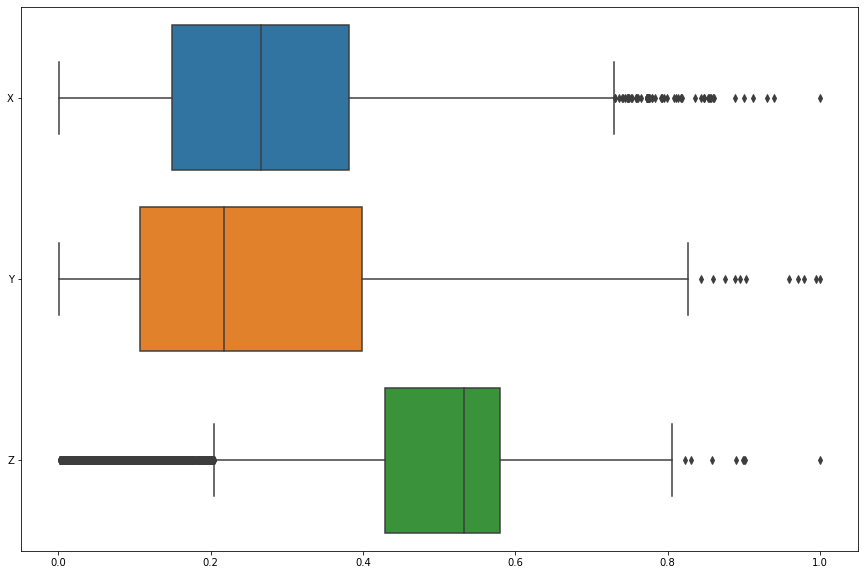

In [6]:
fig, ax = plt.subplots()
fig.set_size_inches(15,10)
ax = sns.boxplot(data=df[['X', 'Y', 'Z']],orient='h')
display(ax)

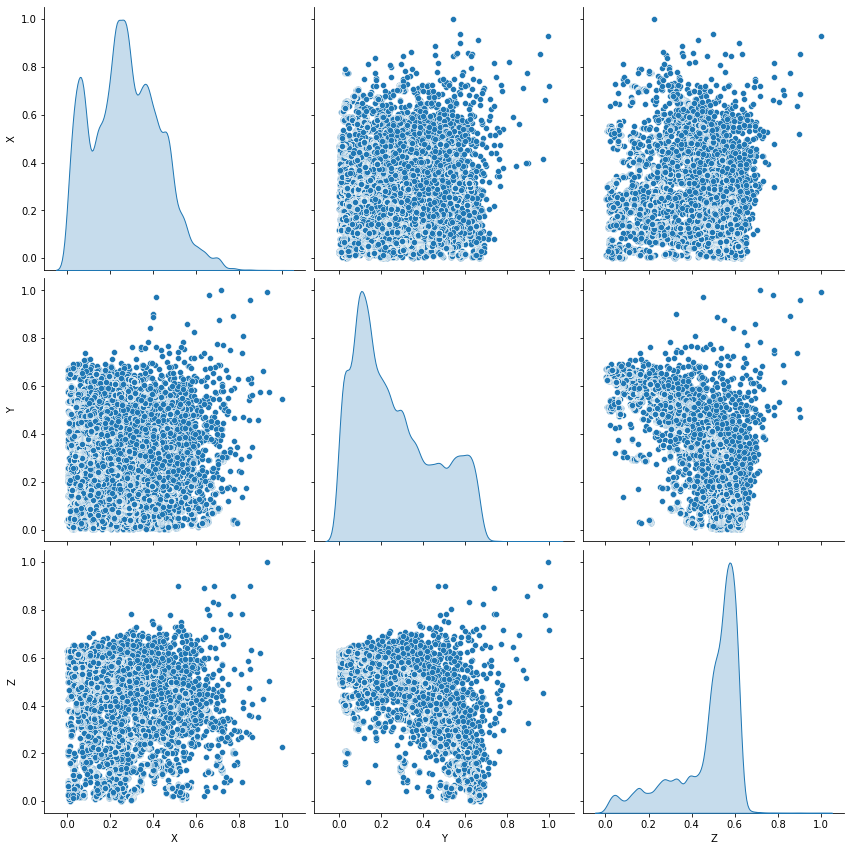

In [7]:
sns.pairplot(df[['X', 'Y', 'Z']], kind="scatter", diag_kind= 'kde', height=4)

In [8]:
df['movement_x'] = df['X'] - df['X'].shift()
df['movement_y'] = df['Y'] - df['Y'].shift()
df['movement_z'] = df['Z'] - df['Z'].shift()
df['modulo'] = (df['X']**2 + df['Y']**2 + df['Z']**2)**0.5
df['modulo_movement'] = (df['movement_x']**2 + df['movement_y']**2 + df['movement_z']**2)**0.5

df

,Time,X,Y,Z,Heart Rate,Labels,movement_x,movement_y,movement_z,modulo,modulo_movement
0,15.0,0.7615,0.3391,0.2419,0.53,0,NaN,NaN,NaN,0.867978,NaN
1,30.0,0.7586,0.2470,0.3424,0.46,0,-0.0029,-0.0921,0.1005,0.868171,0.136349
2,45.0,0.6329,0.3961,0.5692,0.45,0,-0.1257,0.1491,0.2268,0.938854,0.299115
3,60.0,0.2976,0.0890,0.5759,0.44,0,-0.3353,-0.3071,0.0067,0.654330,0.454732
4,75.0,0.2990,0.0902,0.5750,0.42,0,0.0014,0.0012,-0.0009,0.654341,0.002052
...,...,...,...,...,...,...,...,...,...,...,...
51368,29160.0,0.4090,0.0812,0.5418,0.38,5,-0.0015,-0.0049,0.0000,0.683682,0.005124
51369,29175.0,0.4082,0.0785,0.5424,0.38,5,-0.0008,-0.0027,0.0006,0.683365,0.002879
51370,29190.0,0.4095,0.0841,0.5423,0.42,5,0.0013,0.0056,-0.0001,0.684728,0.005750
51371,29205.0,0.4095,0.0845,0.5421,0.44,5,0.0000,0.0004,-0.0002,0.684619,0.000447


In [11]:
df_feature = df.drop('Labels', axis=1).fillna(0)
target = df['Labels']

for steps in range(2):
    print("### AutoFeat with %i feateng_steps" % steps)
    afreg = AutoFeatRegressor(verbose=1, feateng_steps=steps)
    df = afreg.fit_transform(df_feature, target)
    r2 = afreg.score(df_feature, target)
    print("## Final R^2: %.4f" % r2)

### AutoFeat with 0 feateng_steps
[AutoFeat] The 0 step feature engineering process could generate up to 10 features.
[AutoFeat] With 49862 data points this new feature matrix would use about 0.00 gb of space.
[feateng] Warning: no features generated for max_steps < 1.
[featsel] Scaling data...done.
[featsel] Feature selection run 1/5
[featsel] Feature selection run 2/5
[featsel] Feature selection run 3/5
[featsel] Feature selection run 4/5
[featsel] Feature selection run 5/5
[featsel] 10 features after 5 feature selection runs
[featsel] 10 features after correlation filtering
[featsel] 9 features after noise filtering
[AutoFeat] Final dataframe with 10 feature columns (0 new).
[AutoFeat] Training final regression model.
[AutoFeat] Trained model: largest coefficients:
3.9373728904661816
-4.152919 * modulo
-3.333640 * modulo_movement
1.457715 * Heart Rate
1.037370 * movement_x
0.654579 * X
0.566110 * movement_z
0.377097 * Y
-0.144505 * Z
0.000038 * Time
[AutoFeat] Final score: 0.0825
##

In [12]:
df

,Time,X,Y,Z,Heart Rate,movement_x,movement_y,movement_z,modulo,modulo_movement,1/Z,1/X,1/Time,log(Y),log(Time),movement_y**2,movement_z**2,movement_x**2,Abs(movement_x),modulo_movement**3,Abs(movement_z)
0,30.0,0.7586,0.2470,0.3424,0.46,-0.0029,-0.0921,0.1005,0.868171,0.136349,2.920561,1.318218,0.033333,-1.398367,3.401197,8.482410e-03,1.010025e-02,8.410000e-06,0.0029,2.534875e-03,0.1005
1,45.0,0.6329,0.3961,0.5692,0.45,-0.1257,0.1491,0.2268,0.938854,0.299115,1.756852,1.580028,0.022222,-0.926089,3.806662,2.223081e-02,5.143824e-02,1.580049e-02,0.1257,2.676165e-02,0.2268
2,60.0,0.2976,0.0890,0.5759,0.44,-0.3353,-0.3071,0.0067,0.654330,0.454732,1.736413,3.360215,0.016667,-2.419119,4.094345,9.431041e-02,4.489000e-05,1.124261e-01,0.3353,9.403016e-02,0.0067
3,75.0,0.2990,0.0902,0.5750,0.42,0.0014,0.0012,-0.0009,0.654341,0.002052,1.739130,3.344482,0.013333,-2.405726,4.317488,1.440000e-06,8.100000e-07,1.960000e-06,0.0014,8.638198e-09,0.0009
4,90.0,0.2993,0.0931,0.5743,0.42,0.0003,0.0029,-0.0007,0.654270,0.002998,1.741250,3.341129,0.011111,-2.374081,4.499810,8.410000e-06,4.900000e-07,9.000000e-08,0.0003,2.695501e-08,0.0007
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49857,29160.0,0.4090,0.0812,0.5418,0.38,-0.0015,-0.0049,0.0000,0.683682,0.005124,1.845700,2.444988,0.000034,-2.510840,10.280553,2.401000e-05,0.000000e+00,2.250000e-06,0.0015,1.345681e-07,0.0000
49858,29175.0,0.4082,0.0785,0.5424,0.38,-0.0008,-0.0027,0.0006,0.683365,0.002879,1.843658,2.449780,0.000034,-2.544657,10.281067,7.290000e-06,3.600000e-07,6.400000e-07,0.0008,2.386887e-08,0.0006
49859,29190.0,0.4095,0.0841,0.5423,0.42,0.0013,0.0056,-0.0001,0.684728,0.005750,1.843998,2.442002,0.000034,-2.475749,10.281581,3.136000e-05,1.000000e-08,1.690000e-06,0.0013,1.900878e-07,0.0001
49860,29205.0,0.4095,0.0845,0.5421,0.44,0.0000,0.0004,-0.0002,0.684619,0.000447,1.844678,2.442002,0.000034,-2.471004,10.282095,1.600000e-07,4.000000e-08,0.000000e+00,0.0000,8.944272e-11,0.0002


In [16]:
# df = df.drop('Time', axis=1)
# df

,X,Y,Z,Heart Rate,movement_x,movement_y,movement_z,modulo,modulo_movement,1/Z,1/X,1/Time,log(Y),log(Time),movement_y**2,movement_z**2,movement_x**2,Abs(movement_x),modulo_movement**3,Abs(movement_z)
0,0.7586,0.2470,0.3424,0.46,-0.0029,-0.0921,0.1005,0.868171,0.136349,2.920561,1.318218,0.033333,-1.398367,3.401197,8.482410e-03,1.010025e-02,8.410000e-06,0.0029,2.534875e-03,0.1005
1,0.6329,0.3961,0.5692,0.45,-0.1257,0.1491,0.2268,0.938854,0.299115,1.756852,1.580028,0.022222,-0.926089,3.806662,2.223081e-02,5.143824e-02,1.580049e-02,0.1257,2.676165e-02,0.2268
2,0.2976,0.0890,0.5759,0.44,-0.3353,-0.3071,0.0067,0.654330,0.454732,1.736413,3.360215,0.016667,-2.419119,4.094345,9.431041e-02,4.489000e-05,1.124261e-01,0.3353,9.403016e-02,0.0067
3,0.2990,0.0902,0.5750,0.42,0.0014,0.0012,-0.0009,0.654341,0.002052,1.739130,3.344482,0.013333,-2.405726,4.317488,1.440000e-06,8.100000e-07,1.960000e-06,0.0014,8.638198e-09,0.0009
4,0.2993,0.0931,0.5743,0.42,0.0003,0.0029,-0.0007,0.654270,0.002998,1.741250,3.341129,0.011111,-2.374081,4.499810,8.410000e-06,4.900000e-07,9.000000e-08,0.0003,2.695501e-08,0.0007
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49857,0.4090,0.0812,0.5418,0.38,-0.0015,-0.0049,0.0000,0.683682,0.005124,1.845700,2.444988,0.000034,-2.510840,10.280553,2.401000e-05,0.000000e+00,2.250000e-06,0.0015,1.345681e-07,0.0000
49858,0.4082,0.0785,0.5424,0.38,-0.0008,-0.0027,0.0006,0.683365,0.002879,1.843658,2.449780,0.000034,-2.544657,10.281067,7.290000e-06,3.600000e-07,6.400000e-07,0.0008,2.386887e-08,0.0006
49859,0.4095,0.0841,0.5423,0.42,0.0013,0.0056,-0.0001,0.684728,0.005750,1.843998,2.442002,0.000034,-2.475749,10.281581,3.136000e-05,1.000000e-08,1.690000e-06,0.0013,1.900878e-07,0.0001
49860,0.4095,0.0845,0.5421,0.44,0.0000,0.0004,-0.0002,0.684619,0.000447,1.844678,2.442002,0.000034,-2.471004,10.282095,1.600000e-07,4.000000e-08,0.000000e+00,0.0000,8.944272e-11,0.0002


# Split Dataset
Train, Validation and Test

Split the data
We'll use a (70%, 20%, 10%) split for the training, validation, and test sets. Note the data is not being randomly shuffled before splitting. This is for two reasons.

It ensures that chopping the data into windows of consecutive samples is still possible.
It ensures that the validation/test results are more realistic, being evaluated on data collected after the model was trained.

***ANOTHER SPLITING OPTION WOULD BE TO SEPARATE USERS (Crear nueva columna con nombre usuario?? O manejar cada CSV por separado??)***





In [14]:
column_indices = {name: i for i, name in enumerate(df.columns)}

PERCENTAGE_TRAIN = 0.7
PERCENTAGE_VALIDATION = 0.2

# n = len(df)
total_rows = df.shape[0]
train_df = df[0:int(total_rows*PERCENTAGE_TRAIN)]
val_df = df[int(total_rows*PERCENTAGE_TRAIN):int(total_rows*(PERCENTAGE_VALIDATION + PERCENTAGE_TRAIN))]
test_df = df[int(total_rows*(PERCENTAGE_VALIDATION + PERCENTAGE_TRAIN)):]

assert len(train_df) + len(val_df) + len(test_df) == total_rows, 'The split does not match'

In [20]:
column_indices = {name: i for i, name in enumerate(df.columns)}

PERCENTAGE_TRAIN = 0.7
PERCENTAGE_VALIDATION = 0.2

total_rows = df.shape[0]

x_train = df[0:int(total_rows*PERCENTAGE_TRAIN)]
y_train = labels[0:int(total_rows*PERCENTAGE_TRAIN)]

x_val = df[int(total_rows*PERCENTAGE_TRAIN):int(total_rows*(PERCENTAGE_VALIDATION + PERCENTAGE_TRAIN))]
y_val = labels[int(total_rows*PERCENTAGE_TRAIN):int(total_rows*(PERCENTAGE_VALIDATION + PERCENTAGE_TRAIN))]

x_test = df[int(total_rows*(PERCENTAGE_VALIDATION + PERCENTAGE_TRAIN)):]
y_test = labels[int(total_rows*(PERCENTAGE_VALIDATION + PERCENTAGE_TRAIN)):]

assert len(x_train) + len(x_val) + len(x_test) == total_rows, 'The split does not match'
# assert len(y_train) + len(y_val) + len(y_test) == total_rows, 'The split does not match'

# Reshape Data into Segments and Prepare for Keras
The data contained in the dataframe is not ready yet to be fed into a neural network. Therefore we need to reshape it. Let’s create another function for this called “create_segments_and_labels”. This function will take in the dataframe and the label names.

In [ ]:
def create_segments_and_labels(dataframe,labels):

    labels = dataframe[labels]
    segments = dataframe[['Z','Heart Rate']]
    #segments = dataframe[['X','Y','Z','Heart Rate']] #All features

    return segments, labels

In [ ]:
# x --> Features
# y --> Labels
   
x_train, y_train = create_segments_and_labels(train_df,'Labels')
x_val, y_val = create_segments_and_labels(val_df,'Labels')
x_test, y_test = create_segments_and_labels(test_df,'Labels')


assert x_train.shape[0] == len(y_train)
assert x_val.shape[0] == len(y_val)
assert x_test.shape[0] == len(y_test)

# LSTM Model

In [ ]:
# Prepare data for LSTM Model
x_train = np.expand_dims(x_train,-1) 
x_val = np.expand_dims(x_val,-1) 
x_test = np.expand_dims(x_test,-1) 

In [ ]:
# Prepare labels data 
# Needed to categorical_crossentropy loss function
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)
y_test = to_categorical(y_test)

In [ ]:
# Create LSTM model
n_timesteps = x_train.shape[1]
n_features = x_train.shape[2]
n_outputs = 3

model = Sequential()
model.add(LSTM(180, input_shape=(n_timesteps,n_features)))
model.add(Dropout(0.5))
#model.add(Dense(30, activation='relu'))
model.add(Dense(60, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))
model.compile(loss=('categorical_crossentropy',sample_weight()), optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 180)               131040    
_________________________________________________________________
dropout_4 (Dropout)          (None, 180)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 60)                10860     
_________________________________________________________________
dense_10 (Dense)             (None, 3)                 183       
Total params: 142,083
Trainable params: 142,083
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# train model
# history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=150, batch_size=180, verbose=1)

history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=50, batch_size=30, verbose=1)

Epoch 1/50
581/581 [==============================] - 4s 5ms/step - loss: 0.8066 - accuracy: 0.7107 - val_loss: 0.8699 - val_accuracy: 0.6459
Epoch 2/50
581/581 [==============================] - 2s 4ms/step - loss: 0.7635 - accuracy: 0.7244 - val_loss: 0.8637 - val_accuracy: 0.6459
Epoch 3/50
581/581 [==============================] - 3s 5ms/step - loss: 0.7654 - accuracy: 0.7227 - val_loss: 0.8622 - val_accuracy: 0.6459
Epoch 4/50
581/581 [==============================] - 3s 5ms/step - loss: 0.7709 - accuracy: 0.7168 - val_loss: 0.8676 - val_accuracy: 0.6459
Epoch 5/50
581/581 [==============================] - 3s 5ms/step - loss: 0.7588 - accuracy: 0.7241 - val_loss: 0.8596 - val_accuracy: 0.6459
Epoch 6/50
581/581 [==============================] - 3s 5ms/step - loss: 0.7666 - accuracy: 0.7187 - val_loss: 0.8691 - val_accuracy: 0.6459
Epoch 7/50
581/581 [==============================] - 2s 4ms/step - loss: 0.7674 - accuracy: 0.7173 - val_loss: 0.8636 - val_accuracy: 0.6459
Epoch 

In [ ]:
predictions = history.model.predict(x_test)

In [ ]:
guess = 0

to_predict = len(y_test)

for index in range(to_predict):
    if np.argmax(predictions[index]) == np.argmax(y_test[index]):
        guess += 1

# np.argmax(predictions[index]), np.argmax(y_test[index])
print("Guessed: {:.2f}%".format(guess/to_predict*100))

KeyError: ignored

# Deep Neural Network Model in Keras


In [ ]:
# Reverse array dimension changes for LSTM
x_train = x_train[:, :, 0]
x_val = x_val[:, :, 0]
x_test = x_test[:, :, 0]

In [ ]:
#Prepare labels data 
#Needed ONLY for categorical_crossentropy loss function
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)
y_test = to_categorical(y_test)

In [ ]:
# define the keras model
num_classes = 3

model = Sequential()
model.add(Dense(30, input_dim= x_train.shape[1], activation='relu'))
#model.add(Dense(60, activation='relu'))
model.add(Dense(num_classes, activation='softmax')) #Last layer corresponds with the number of possible outputs

# compile the keras model
opt = SGD(learning_rate=0.01, momentum=0.9)

model.compile(loss= 'categorical_crossentropy', optimizer= 'adam', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 30)                150       
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 93        
Total params: 243
Trainable params: 243
Non-trainable params: 0
_________________________________________________________________


Train Model

In [ ]:
# fit the keras model on the dataset
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=50, batch_size=180, verbose=1)

# Evaluate Model on Test Data

In [ ]:
# evaluate the model
test_loss, test_acc = model.evaluate(x_test, y_test)

print("Test accuracy", test_acc)
print("Test loss", test_loss)

78/78 [==============================] - 0s 2ms/step - loss: 0.8309 - accuracy: 0.6655
Test accuracy 0.6654604077339172
Test loss 0.8309272527694702


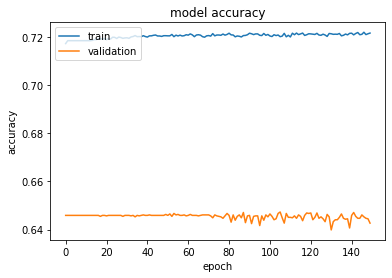

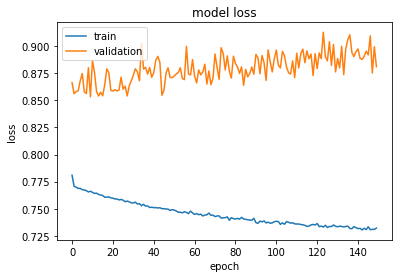

In [ ]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

Confusion Matrix for LSTM

In [ ]:
def show_confusion_matrix(validations, predictions):

    matrix = metrics.confusion_matrix(validations, predictions)
    plt.figure(figsize=(6, 4))
    sns.heatmap(matrix,
                cmap='coolwarm',
                linecolor='white',
                linewidths=1,
                #xticklabels=LABELS,
                #yticklabels='0','1','2',
                annot=True,
                fmt='d')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

In [ ]:
y_pred_test = model.predict(x_test)
# Take the class with the highest probability from the test predictions
max_y_pred_test = np.argmax(y_pred_test, axis=1)
max_y_test = np.argmax(y_test, axis=1)

show_confusion_matrix(max_y_test, max_y_pred_test)

print(classification_report(max_y_test, max_y_pred_test))

ValueError: ignored

# Predictions

In [ ]:
# test the trained model with the full x_test
predictions = model.predict(x_test)

In [ ]:
predictions[0], y_test[0]

(array([0.02846027, 0.89990205, 0.07163768], dtype=float32),
 array([0., 1., 0.], dtype=float32))

In [ ]:
predictions[500], y_test[500]

(array([0.05969261, 0.7548642 , 0.18544324], dtype=float32),
 array([0., 1., 0.], dtype=float32))

In [ ]:
predictions[800], y_test[800]

(array([0.06639516, 0.5557858 , 0.37781912], dtype=float32),
 array([0., 1., 0.], dtype=float32))

In [ ]:
predictions[1200], y_test[1200]

(array([0.04926674, 0.74609387, 0.20463938], dtype=float32),
 array([0., 1., 0.], dtype=float32))

In [ ]:
predictions[2000], y_test[2000] # bad prediction

NameError: ignored

In [ ]:
predictions[2400], y_test[2400]

(array([0.05789682, 0.83688635, 0.10521688], dtype=float32),
 array([0., 1., 0.], dtype=float32))

In [ ]:
for i in range(2000):
    predictions[i]

NameError: ignored

In [ ]:
# fit and evaluate a model
def evaluate_model(trainX, trainy, valX, valy):
    verbose, epochs, batch_size = 1, 100, 100

    n_timesteps = trainX.shape[1]
    n_features = trainX.shape[2]
    n_outputs = 3

    model = Sequential()
    model.add(LSTM(180, input_shape=(n_timesteps,n_features)))
    model.add(Dropout(0.5))
    model.add(Dense(30, activation='relu'))
    model.add(Dense(n_outputs, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    #model.summary()
	# fit network
    history = model.fit(trainX, trainy, validation_data=(valX, valy), epochs=epochs, batch_size=batch_size, verbose=verbose)
	# evaluate model
    _, accuracy = model.evaluate(trainX, trainy, batch_size=batch_size, verbose=verbose)
    return accuracy

In [ ]:
# summarize scores
def summarize_results(scores):
	print(scores)
	m, s = mean(scores), std(scores)
	print('Accuracy: %.3f%% (+/-%.3f)' % (m, s))

In [ ]:
def run_experiment(repeats=2):
	# repeat experiment
	scores = list()
	for r in range(repeats):
		score = evaluate_model(x_train, y_train, x_val, y_val)
		score = score * 100.0
		print('>#%d: %.3f' % (r+1, score))
		scores.append(score)
	# summarize results
	summarize_results(scores)

In [ ]:
#Train model just 1 time
evaluate_model(x_train, y_train, x_val, y_val)

In [ ]:
#Run full training experiment
run_experiment()

>#1: 72.368
>#2: 72.610
>#3: 73.087
[72.36849069595337, 72.60979413986206, 73.08703064918518]
Accuracy: 72.688% (+/-0.299)
